In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline
plt.rcParams["figure.figsize"] =(12,9)
sns.set(style="white")

Data sources:

1. Crytocurrency market data for the coins: bitcoin, ethereum, litecoin, ripple
2. Stocktwits user-provided sentiment data fetched using Quantopian
3. Google trends data on search terms for the above coins (Strong correlation as per Google Correlate)

In [2]:
# 1. Cryptocurrency market data
# get market data for cryptocurrencies from the start of Aug 7, 2015 to Feb 14
start_date_ = '2015-08-07'
end_date_ = '2018-04-18'

start_date = start_date_.replace("-", "")
end_date = end_date_.replace("-", "")

In [3]:
# TODO: Add config class/file that is accessible to all notebooks
coins = ['bitcoin', 'ethereum', 'litecoin', 'ripple']
coin_symbol = {'bitcoin': 'btc', 'ethereum': 'eth', 'litecoin': 'ltc', 'ripple': 'xrp'}

coin_df = {}

In [4]:
for coin in coins:
    coin_df[coin] = pd.read_html("https://coinmarketcap.com/currencies/"+coin+"/historical-data/?start="+start_date+"&end="+end_date)[0]
    coin_df[coin] = coin_df[coin].assign(Date=pd.to_datetime(coin_df[coin]['Date']))
    
    # reverse the data frame so that subsequent rows represent later timepoints
    coin_df[coin] = coin_df[coin].sort_values(by='Date').reset_index(drop=True)
    
    coin_df[coin].to_pickle("data/"+coin+".pkl")

In [5]:
coin_df['bitcoin'].tail()

,Date,Open,High,Low,Close,Volume,Market Cap
981,2018-04-14,7874.67,8140.71,7846.00,7986.24,5191430000,133682000000
982,2018-04-15,7999.33,8338.42,7999.33,8329.11,5244480000,135812000000
983,2018-04-16,8337.57,8371.15,7925.73,8058.67,5631310000,141571000000
984,2018-04-17,8071.66,8285.96,7881.72,7902.09,6900880000,137070000000
985,2018-04-18,7944.43,8197.80,7886.01,8163.42,6529910000,134926000000


In [6]:
coin_df['bitcoin'].dtypes

Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                 int64
Market Cap             int64
dtype: object

In [7]:
coin_df['bitcoin'].describe()

,Open,High,Low,Close,Volume,Market Cap
count,986.000000,986.000000,986.000000,986.000000,9.860000e+02,9.860000e+02
mean,2831.044097,2938.641440,2712.021917,2838.478550,1.870023e+09,4.700170e+10
std,3976.461741,4157.478245,3752.271858,3978.628799,3.747883e+09,6.699739e+10
min,210.070000,226.320000,199.570000,210.500000,1.271260e+07,3.053250e+09
25%,443.000000,448.360000,436.627500,442.815000,6.084652e+07,6.756688e+09
50%,774.965000,781.365000,768.905000,777.850000,1.345960e+08,1.244570e+10
75%,3622.585000,3786.680000,3477.252500,3630.955000,1.554205e+09,6.005368e+10
max,19475.800000,20089.000000,18974.100000,19497.400000,2.384090e+10,3.261410e+11


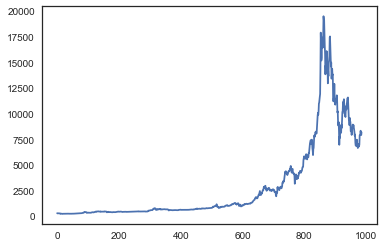

In [8]:
plt.plot(coin_df['bitcoin']['Close'])

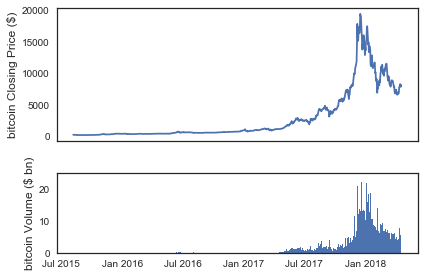

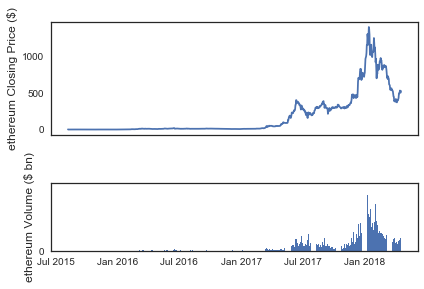

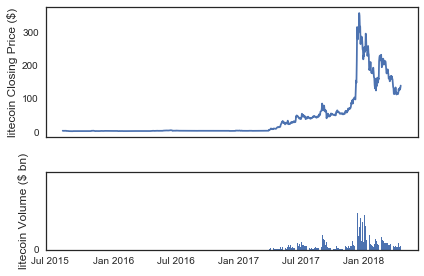

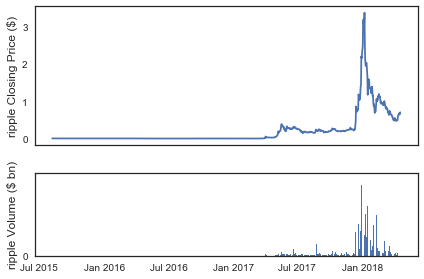

In [9]:
for coin in coins:
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 3]})
    ax1.set_ylabel(coin+' Closing Price ($)',fontsize=12)
    ax2.set_ylabel(coin+' Volume ($ bn)',fontsize=12)
    ax2.set_yticks([int('%d000000000'%i) for i in [0, 10, 20, 30]])
    ax2.set_yticklabels([0, 10, 20, 30])
    ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
    ax1.plot(coin_df[coin]['Date'],coin_df[coin]['Close'])
    ax2.bar(coin_df[coin]['Date'].values, coin_df[coin]['Volume'].values)
    fig.tight_layout()
    plt.show()

Onto the 2nd Data Source: Sentiment from Stocktwits

I couldn't get free access to any data (twitter, stocktwits or reddit). Raw tweets are not accessed, instead the bullish and bearish sentiment information is fetched directly. This is the sentiment expressed by users on stocktwits.

Leveraged the Qunatopian platform directly to export the required dataset

Code here: https://www.quantopian.com/research/notebooks/Updated%20PsychSignal.Stockwits.ipynb 
Also checked-into Github capstone area


****NOTE**** Quantopian didn't approve the usage of output data from this notebook, so I am not including the sentiment data in my final submission

Google trends is the last data source used. Used the python package pytrends to fetch daily google search results data for the keywords "bitcoin" and "ethereum" seperately.

Since Google trends provides daily data only if the search window is less than 6 months and normalizes the data on a scale of 1 to 100, I had to create multiple short queries and then accumulate the data for the required time window. While accumulating, I also took care to re-scale the data by having an overlap time window between each successive queries (Code below)

In [10]:
from pytrends.request import TrendReq
from datetime import datetime, timedelta

# Connect to Google
pytrend = TrendReq(hl='de-CH')
# pytrend = TrendReq(hl='en-US', tz=360)

In [11]:
# Generates per-day google trends data even when query duration is greater than 6 months
# Accumulates data by using multiple queries and scaling query results appropriately 
# by having overlapped dates in successive queries 
def get_trends_data (keyword, start_date, end_date, overlap):
    
    print ("!!!!!!!!!!Searching for keyword: ", keyword)
    
    # this works as of 4/14 for at least the search terms I tried. Google trends might change its behavior
    max_delta = 180 # in days
    
    # Create time_set array
    time_set = []
    first = start_date
    last = start_date
    while last < end_date:
        last = min(end_date, first + timedelta(days=max_delta))
        time_set.append(first.strftime('%Y-%m-%d')+' '+last.strftime('%Y-%m-%d'))
        first = (last + timedelta(days=1)) - timedelta(days=overlap)
                  
    # print (time_set)
    
    # Initialize output dataframe
    results_df = pd.DataFrame()

    # Skip re-scaling for the first iteration
    first_iter = 1

    for time_dur in time_set:
        pytrend.build_payload(kw_list=[keyword], timeframe=time_dur, geo='', gprop='')
        trend_df = pytrend.interest_over_time()
    
        if first_iter == 1:
            first_iter = 0
            overlap = 0
        else:
            overlap = (prev_end_date - trend_df.index[0]).days + 1
            # print (overlap)
    
            if overlap < 1:
                print ("ERROR: Killing since overlap is not even one day: Overlap =", overlap)
                exit(1)
            else:
                print ("Proceeding since overlap is", overlap)
      
            if overlap > 1:
                prev_df = results_df.iloc[-1*overlap:][keyword]
                curr_df = trend_df.iloc[:overlap][keyword]
                scale_fac = np.mean(1.0*prev_df/curr_df)
                print (scale_fac)
            else:
                print ("Overlap is greater than 1. overlap =", overlap)
        
            trend_df[keyword] *= scale_fac
    
        prev_end_date = trend_df.index[-1]
    
        # Interest Over Time
        results_df = results_df.append(trend_df.iloc[overlap:]) #, ignore_index = True)

    return results_df

In [12]:
start_date_format = datetime.strptime(start_date_, '%Y-%m-%d')
end_date_format = datetime.strptime(end_date_, '%Y-%m-%d')

overlap = 10

keywords = ['bitcoin', 'ethereum', 'litecoin', 'ripple']
keyword_df = {}

!!!!!!!!!!Searching for keyword:  bitcoin
Proceeding since overlap is 10
1.1676765188834153
Proceeding since overlap is 10
1.3415746228249463
Proceeding since overlap is 10
3.9584863657376204
Proceeding since overlap is 10
22.428281083334024
Proceeding since overlap is 10
23.11529331134576
!!!!!!!!!!Searching for keyword:  ethereum
Proceeding since overlap is 10
6.714603174603175
Proceeding since overlap is 10
3.011235766192892
Proceeding since overlap is 10
44.164791237495756
Proceeding since overlap is 10
59.64202317348527
Proceeding since overlap is 10
59.39316574810751
!!!!!!!!!!Searching for keyword:  litecoin
Proceeding since overlap is 10
1.1007969936406121
Proceeding since overlap is 10
1.0967932463634604
Proceeding since overlap is 10
22.65243651489333
Proceeding since overlap is 10
329.21541068311643
Proceeding since overlap is 10
333.9617268774431
!!!!!!!!!!Searching for keyword:  ripple
Proceeding since overlap is 10
1.0966622042540222
Proceeding since overlap is 10
1.24696

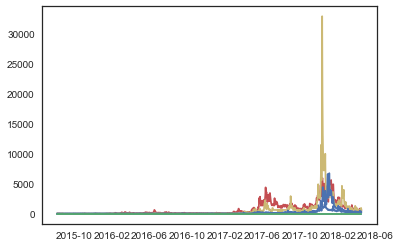

In [13]:
for search_term in keywords:
    keyword_df[search_term] = get_trends_data(search_term, start_date_format, end_date_format, overlap)
    plt.plot(keyword_df[search_term])

In [14]:
keyword_df['litecoin'].index[-1]

Timestamp('2018-04-18 00:00:00')

In [15]:
# Impute unavailable trends data (in case we don't have the data yet until end_data from Google Trends)
for search_term in keywords:
    while (keyword_df[search_term].index[-1] < end_date_format):
        new_date = keyword_df[search_term].index[-1] + timedelta(days=1)
        new_entry = pd.DataFrame(keyword_df[search_term][-1:].values, index=[new_date], columns=keyword_df[search_term].columns)
        
        # print (new_date)
        # print (new_entry)
        
        keyword_df[search_term] = keyword_df[search_term].append(new_entry)

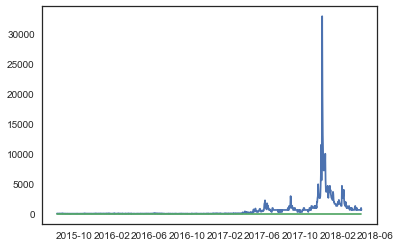

In [16]:
plt.plot(keyword_df['litecoin'])

In [17]:
keyword_df['litecoin'].tail()

,litecoin,isPartial
date,,
2018-04-14,667.923454,False
2018-04-15,667.923454,False
2018-04-16,667.923454,False
2018-04-17,1001.885181,False
2018-04-18,667.923454,False


In [18]:
for search_term in keywords:
    
    # print search_term
    # print keyword_df[search_term]
    
    keyword_df[search_term].reset_index(inplace=True)
    keyword_df[search_term].drop(['isPartial'], axis=1, inplace=True)
    
    keyword_df[search_term].rename(index=str, columns={"date": "Date"}, inplace=True)
        
    keyword_df[search_term].columns =[keyword_df[search_term].columns[0]]+[coin_symbol[i]+"_trends" for i in keyword_df[search_term].columns[1:]]
        
    keyword_df[search_term].to_pickle("data/"+search_term+"_trends.pkl")

In [19]:
keyword_df['litecoin'].rename(index=str, columns={"date": "Date"}, inplace=True)

In [20]:
keyword_df['litecoin'].tail()

,Date,ltc_trends
981,2018-04-14,667.923454
982,2018-04-15,667.923454
983,2018-04-16,667.923454
984,2018-04-17,1001.885181
985,2018-04-18,667.923454


## Combine all the data sources to create the full dataset

In [21]:
for coin in coins:
    coin_df[coin].columns =[coin_df[coin].columns[0]]+[coin_symbol[coin]+"_"+i for i in coin_df[coin].columns[1:]]

In [22]:
market_df = pd.DataFrame()
# for coin in coins:
#     market_df = pd.merge(market_df, coin_df[coin], on=['Date'])

market_df1 = pd.merge(coin_df['bitcoin'], coin_df['ethereum'], on=['Date'])
market_df2 = pd.merge(coin_df['litecoin'], coin_df['ripple'], on=['Date'])
market_df = pd.merge(market_df1, market_df2, on=['Date'])

market_df = market_df[market_df['Date']>=start_date_]

# Exploratory Data Analysis & Feature Engineering

Understand the correlation between the features

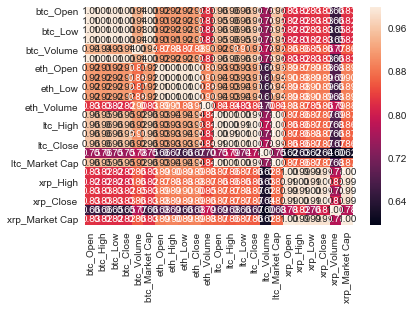

In [23]:
sns.heatmap(market_df.corr(), annot=True, fmt=".2f")

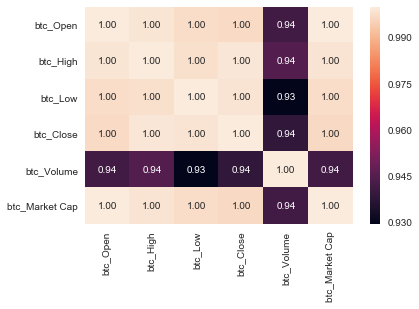

In [24]:
sns.heatmap(coin_df['bitcoin'].corr(), annot=True, fmt=".2f")

# Feature Selection & Feature Engineering

Open, Close, High & Low are very highly correlated. Also correlated with volume to a great extent. Pick just Volume and Close among these. Instead add these new features:

1. Daily returns
2. Volatility
3. Close Off High
4. 7-day mean returns
5. 30-day mean returns

In [25]:
# New features
for coin, symbol in coin_symbol.items():
    kwargs = {symbol+'_close_off_high': lambda x: 1-2*(x[symbol+'_High']-x[symbol+'_Close'])/(x[symbol+'_High']-x[symbol+'_Low']),
              symbol+'_volatility': lambda x: (x[symbol+'_High']- x[symbol+'_Low'])/x[symbol+'_Open'],
              symbol+'_daily_ret': lambda x: (x[symbol+'_Close']-x[symbol+'_Open'])/x[symbol+'_Open']
              # symbol+'_coin_supply': lambda x: (x[symbol+'_Market Cap'])/x[symbol+'_Open']  # TBD
             }
    market_df = market_df.assign(**kwargs)
    
    market_df[symbol+'_7day_ret'] = market_df[symbol+'_daily_ret'].rolling(7).mean()
    # Note: Probably better to get the mean() so far for these NA's
    market_df[symbol+'_7day_ret'] = market_df[symbol+'_7day_ret'].fillna(market_df[symbol+'_daily_ret'])
    
    market_df[symbol+'_30day_ret'] = market_df[symbol+'_daily_ret'].rolling(30).mean()
    market_df[symbol+'_30day_ret'] = market_df[symbol+'_30day_ret'].fillna(market_df[symbol+'_daily_ret'])
    
    market_df.drop([symbol+'_High', symbol+'_Low', symbol+'_Open', symbol+'_Market Cap'], axis=1, inplace=True)


market_df.head(10)

,Date,btc_Close,btc_Volume,eth_Close,eth_Volume,ltc_Close,ltc_Volume,xrp_Close,xrp_Volume,btc_close_off_high,...,ltc_close_off_high,ltc_volatility,ltc_daily_ret,ltc_7day_ret,ltc_30day_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret,xrp_7day_ret,xrp_30day_ret
0,2015-08-07,279.58,42484800,2.770000,164329,4.21,4192810,0.008152,363643,0.597015,...,0.920000,0.061576,0.036946,0.036946,0.036946,0.987805,0.020449,0.016459,0.016459,0.016459
1,2015-08-08,261.00,58533000,0.753325,674188,3.85,4917730,0.008476,678295,-0.969823,...,-0.947368,0.090047,-0.087678,-0.087678,-0.087678,0.147059,0.066634,0.038217,0.038217,0.038217
2,2015-08-09,265.08,23789600,0.701897,532170,3.90,3064680,0.008808,531969,0.411945,...,0.058824,0.044271,0.015625,0.015625,0.015625,0.914530,0.041372,0.038190,0.038190,0.038190
3,2015-08-10,264.47,20979400,0.708448,405283,3.95,2239890,0.008750,472973,-0.155756,...,0.250000,0.020513,0.012821,0.012821,0.012821,-0.949686,0.018044,-0.007036,-0.007036,-0.007036
4,2015-08-11,270.39,25433900,1.070000,1463100,4.16,3426300,0.008591,282461,1.000000,...,1.000000,0.055696,0.053165,0.053165,0.053165,-1.000000,0.019998,-0.018284,-0.018284,-0.018284
5,2015-08-12,266.38,26815400,1.220000,2150620,3.99,3519900,0.008271,287463,-0.650000,...,-0.789474,0.045894,-0.036232,-0.036232,-0.036232,-1.000000,0.037481,-0.037248,-0.037248,-0.037248
6,2015-08-13,264.08,27685500,1.830000,4068680,3.88,2409030,0.008147,202934,-0.268437,...,-0.384615,0.032746,-0.022670,-0.004003,-0.022670,-0.983471,0.014638,-0.014396,0.002272,-0.014396
7,2015-08-14,265.68,27091200,1.830000,4637030,4.03,3157170,0.008337,423163,0.402337,...,0.619048,0.054124,0.038660,-0.003759,0.038660,0.984848,0.032401,0.023196,0.003234,0.023196
8,2015-08-15,261.55,19321100,1.690000,2554360,3.93,2016290,0.008420,176135,-0.906890,...,-0.833333,0.029851,-0.022388,0.005569,-0.022388,0.357143,0.016807,0.010804,-0.000682,0.010804
9,2015-08-16,258.51,29717000,1.570000,3550790,3.95,3197720,0.008315,301654,-0.455556,...,0.200000,0.025445,0.005089,0.004063,0.005089,-0.908257,0.012947,-0.012353,-0.007902,-0.012353


In [26]:
# Merge google trends data
for search_term in keywords:
    market_df = market_df.merge(keyword_df[search_term], on=['Date'])

Further analysis after merging the trends data

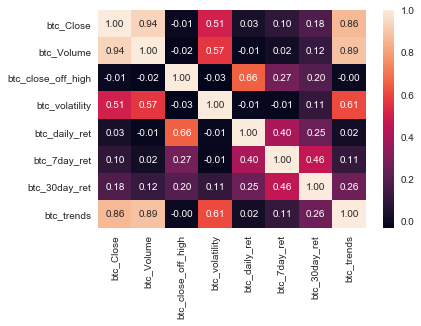

In [27]:
sns.heatmap(market_df[[ x for x in market_df.columns if "btc_" in x]].corr(), annot=True, fmt=".2f")

In [28]:
market_df.columns

Index(['Date', 'btc_Close', 'btc_Volume', 'eth_Close', 'eth_Volume',
       'ltc_Close', 'ltc_Volume', 'xrp_Close', 'xrp_Volume',
       'btc_close_off_high', 'btc_volatility', 'btc_daily_ret', 'btc_7day_ret',
       'btc_30day_ret', 'eth_close_off_high', 'eth_volatility',
       'eth_daily_ret', 'eth_7day_ret', 'eth_30day_ret', 'ltc_close_off_high',
       'ltc_volatility', 'ltc_daily_ret', 'ltc_7day_ret', 'ltc_30day_ret',
       'xrp_close_off_high', 'xrp_volatility', 'xrp_daily_ret', 'xrp_7day_ret',
       'xrp_30day_ret', 'btc_trends', 'eth_trends', 'ltc_trends',
       'xrp_trends'],
      dtype='object')

In [29]:
len(market_df.columns)

33

In [30]:
# SAVE THE DATAFRAME
market_df.to_pickle("data/full_dataset.pkl")

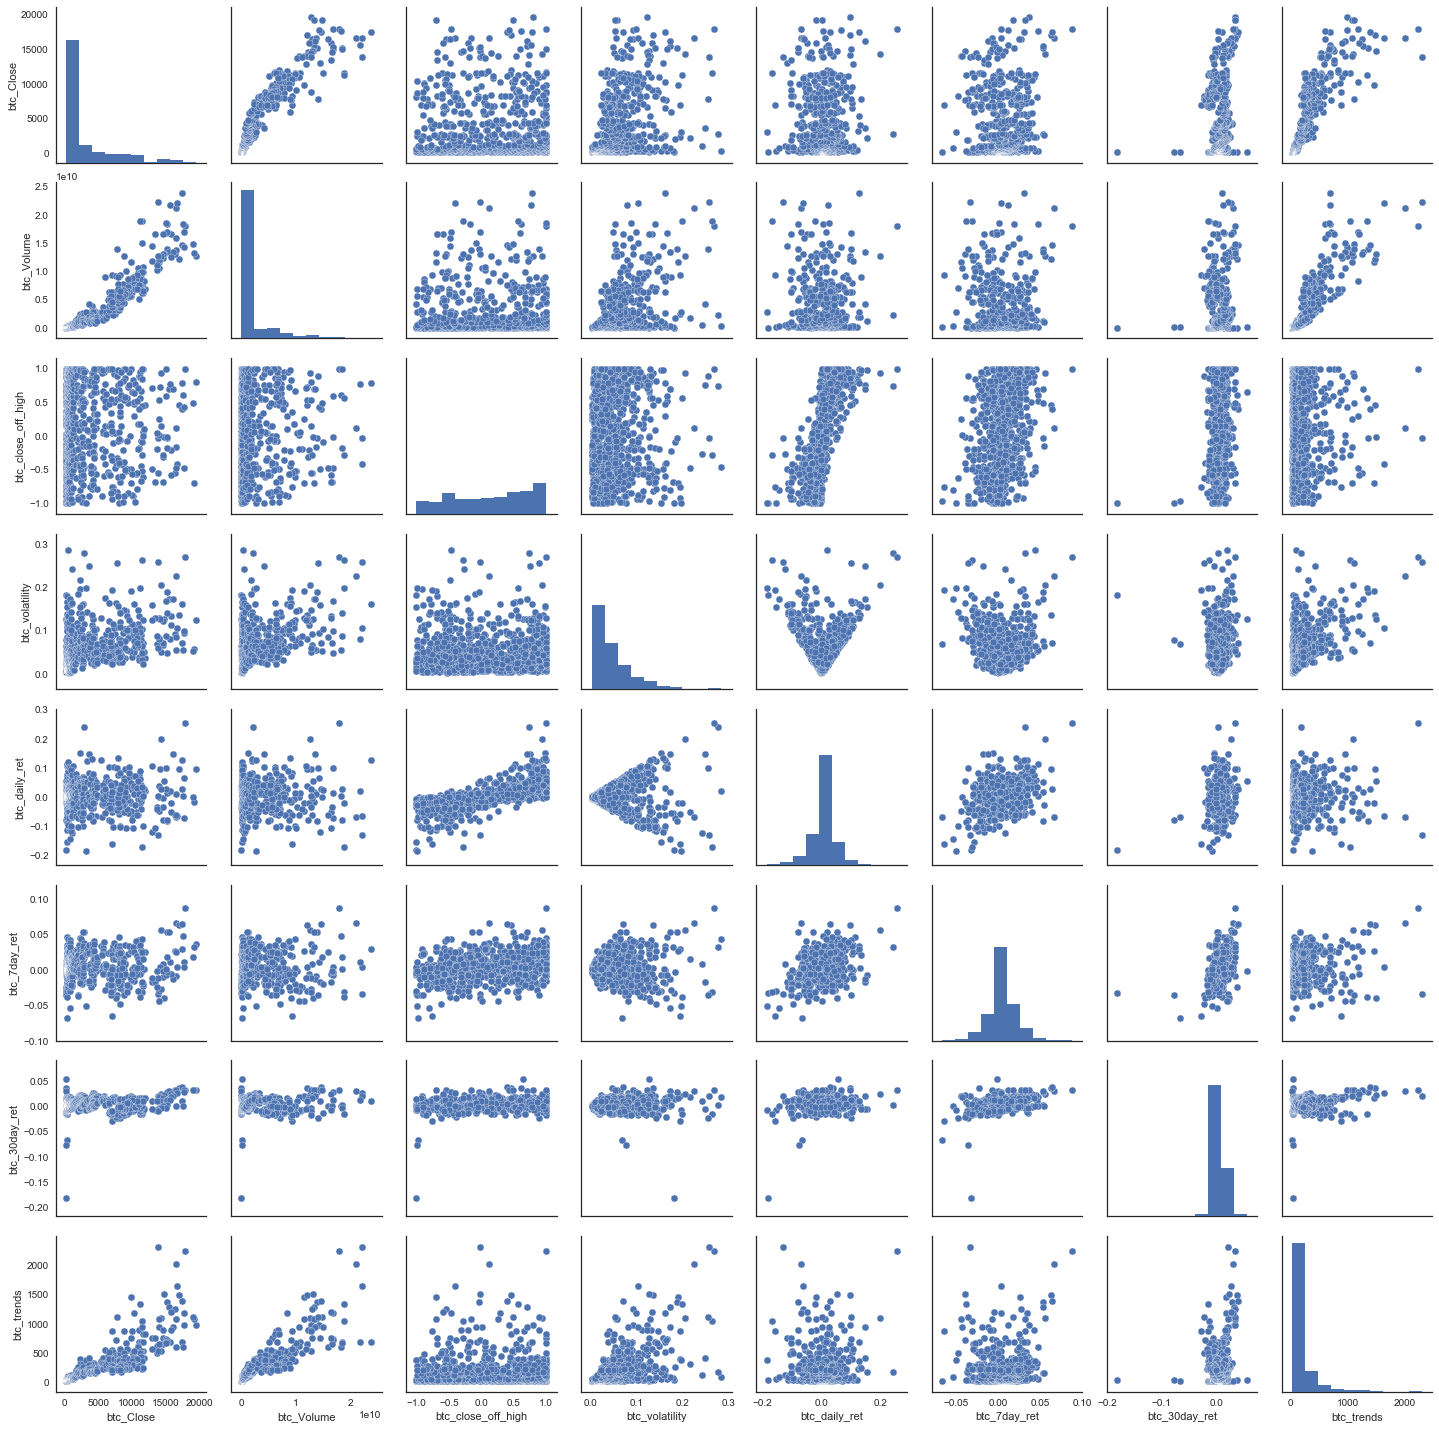

In [31]:
sns.pairplot(market_df[[ x for x in market_df.columns if "btc_" in x]])

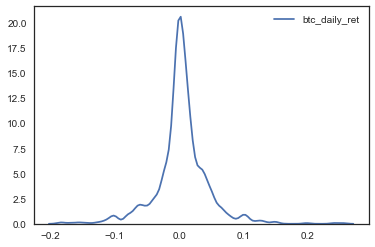

In [32]:
sns.kdeplot(market_df['btc_daily_ret'])

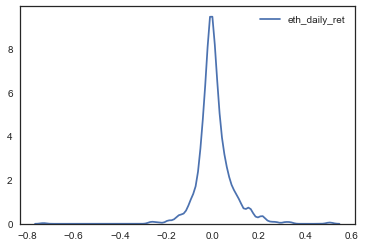

In [33]:
sns.kdeplot(market_df['eth_daily_ret'])

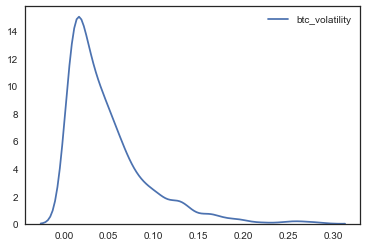

In [34]:
sns.kdeplot(market_df['btc_volatility'])

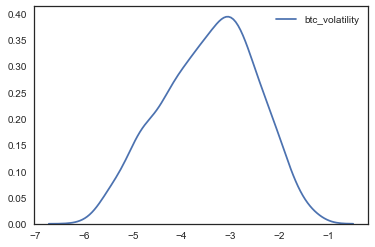

In [35]:
sns.kdeplot(np.log(market_df['btc_volatility']))

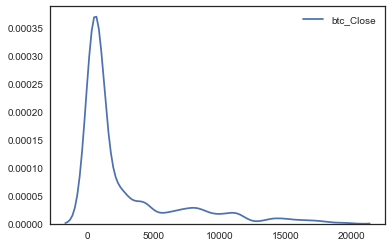

In [36]:
sns.kdeplot(market_df['btc_Close'])

TODO: Some features might benefit from log-transformation - Unclear which ones obviously have a long tail distribution?
Such analysis should be performed only after analyzing just the training test.